In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# === Carica i dati ===
path = "Database/classification_results_by_category.csv"
df = pd.read_csv(path)

features = ["toxicity", "severe_toxicity", "obscene", "threat", "insult", "identity_attack"]

X = df[features].astype(float).values
Xz = StandardScaler().fit_transform(X)

# === PCA con 6 componenti ===
pca = PCA(n_components=6, random_state=0)
Z = pca.fit_transform(Xz)

# === Loadings (coeff. di correlazione tra variabile e componente) ===
loadings = pd.DataFrame(
    pca.components_.T,
    index=features,
    columns=[f"PC{i+1}" for i in range(6)]
)

# --- Contributi "signed": mantengono il segno del loading ma pesano con il quadrato ---
sq = loadings ** 2
abs_contrib_pct = sq.div(sq.sum(axis=0), axis=1) * 100          # contributi in % (tutti positivi, sommano a 100 per colonna)
signed_contrib_pct = np.sign(loadings) * abs_contrib_pct        # stessi pesi ma con segno del loading

# --- Aggiungo riga con varianza spiegata ---
abs_contrib_pct.loc["Total variance explained"] = pca.explained_variance_ratio_ * 100
signed_contrib_pct.loc["Total variance explained"] = pca.explained_variance_ratio_ * 100

# --- Mostra tabelle (preferenza: mostrare direttamente i DataFrame) ---
abs_contrib_pct.round(2)
signed_contrib_pct.round(2)



,PC1,PC2,PC3,PC4,PC5,PC6
toxicity,23.29,0.21,-9.31,-18.26,-5.04,43.89
severe_toxicity,18.93,-0.04,9.55,60.70,-0.00,10.79
obscene,21.49,-7.39,-11.15,1.16,-25.74,-33.07
threat,1.90,83.81,-8.46,1.96,0.44,-3.43
insult,21.57,-3.87,-2.17,-1.48,67.19,-3.73
identity_attack,12.83,4.68,59.37,-16.44,-1.59,-5.08
Total variance explained,57.00,17.12,12.07,7.53,4.89,1.40


C:\Users\01and\AppData\Local\Temp\ipykernel_8836\3930800563.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("_category_ordered", sort=False)[["PC1","PC2","PC3"]]


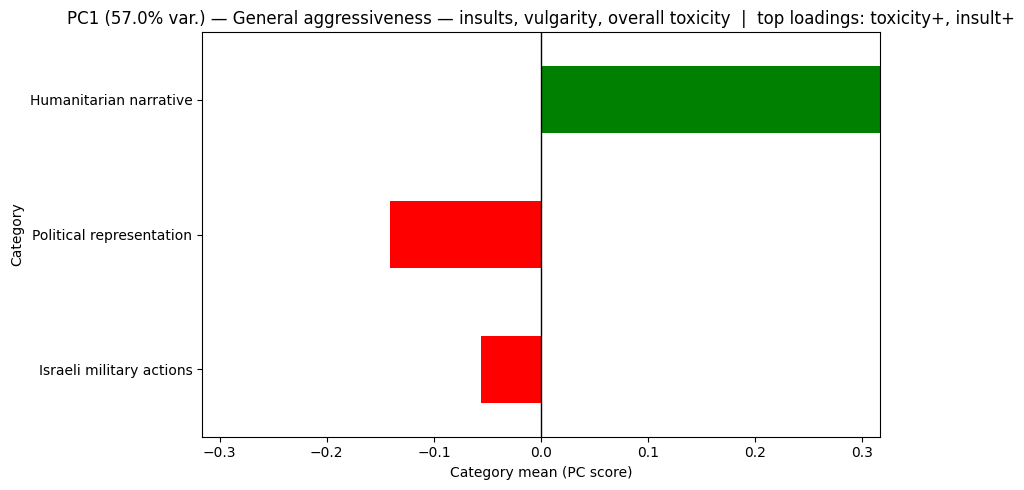

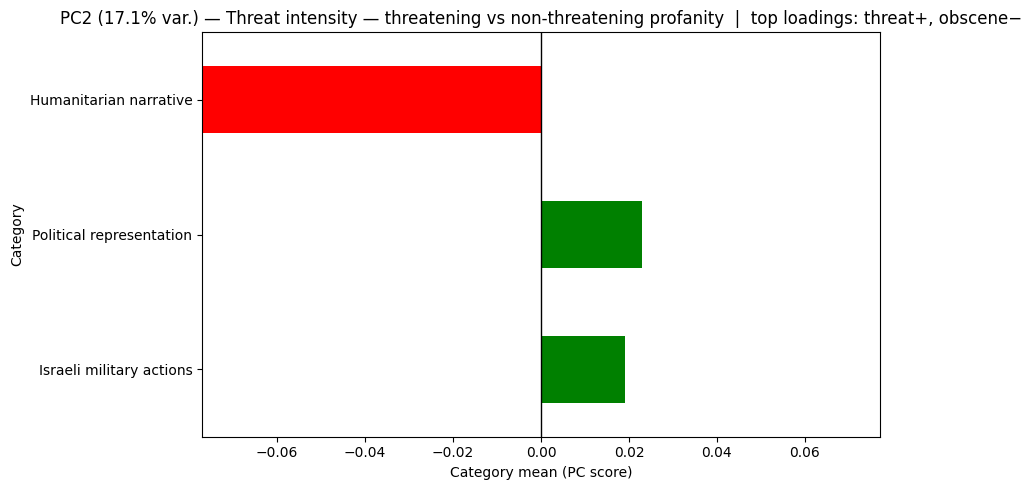

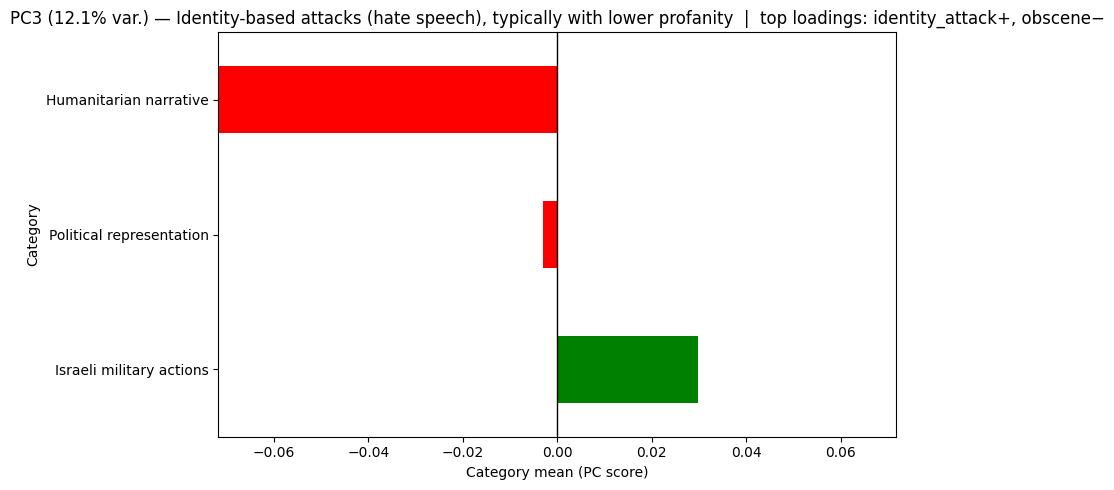

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# === Load data ===
path = "Database/classification_results_by_category.csv"
df = pd.read_csv(path)

features = ["toxicity", "severe_toxicity", "obscene", "threat", "insult", "identity_attack"]

# Preserve a consistent category order (first appearance in the file)
category_order = pd.Index(df["category"].dropna().unique())

# === PCA (3 components) ===
X = df[features].astype(float).values
Xz = StandardScaler().fit_transform(X)

pca = PCA(n_components=3, random_state=0)
Z = pca.fit_transform(Xz)
loadings = pd.DataFrame(pca.components_.T, index=features, columns=["PC1","PC2","PC3"])
explained = pca.explained_variance_ratio_

# --- Sign convention: make the largest-abs loading positive for each PC
for comp in ["PC1","PC2","PC3"]:
    top_feat = loadings[comp].abs().idxmax()
    if np.sign(loadings.loc[top_feat, comp]) < 0:
        loadings[comp] *= -1
        Z[:, int(comp[-1]) - 1] *= -1

# Add scores back
df["PC1"], df["PC2"], df["PC3"] = Z[:,0], Z[:,1], Z[:,2]

# === Category means with fixed order ===
df["_category_ordered"] = pd.Categorical(df["category"], categories=category_order, ordered=True)
scores_mean = (
    df.groupby("_category_ordered", sort=False)[["PC1","PC2","PC3"]]
      .mean()
      .rename_axis("category")
)

# === Descriptive English titles ===
def comp_label(name, var_ratio, load_col):
    # top 2 loadings with signs
    top2 = load_col.abs().sort_values(ascending=False).index[:2]
    signs = ["+" if load_col[f] >= 0 else "−" for f in top2]
    if name == "PC1":
        desc = "General aggressiveness — insults, vulgarity, overall toxicity"
    elif name == "PC2":
        desc = "Threat intensity — threatening vs non-threatening profanity"
    else:  # PC3
        desc = "Identity-based attacks (hate speech), typically with lower profanity"
    return f"{name} ({var_ratio*100:.1f}% var.) — {desc}  |  top loadings: {top2[0]}{signs[0]}, {top2[1]}{signs[1]}"

titles = {
    "PC1": comp_label("PC1", explained[0], loadings["PC1"]),
    "PC2": comp_label("PC2", explained[1], loadings["PC2"]),
    "PC3": comp_label("PC3", explained[2], loadings["PC3"]),
}

# === Plot: horizontal bars with zero centered; green for >0, red for <0 ===
for comp in ["PC1","PC2","PC3"]:
    # keep same category order across all charts
    series = scores_mean[comp].reindex(category_order)

    colors = ["green" if v >= 0 else "red" for v in series.values]
    ax = series.plot(
        kind="barh",
        figsize=(9, 5),
        color=colors,
        title=titles[comp],
        legend=False
    )
    # symmetric x-limits around 0
    max_abs = np.nanmax(np.abs(series.values))
    ax.set_xlim(-max_abs, max_abs)
    ax.axvline(0, color="black", linewidth=1)
    ax.set_xlabel("Category mean (PC score)")
    ax.set_ylabel("Category")
    plt.tight_layout()
    plt.show()
